In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold  # Import KFold for cross-validation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ConvNeXtBase
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.applications import NASNetLarge
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Multiply
from tensorflow.keras import layers
# Define data loading and preprocessing
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
PATH = 'AD Data'
max_samples_per_class = 5000  # Maximum samples per class

def load_samples_from_directory(directory_path, max_samples_per_class):
    class_data = {}  # Dictionary to hold samples for each class

    for class_name in os.listdir(directory_path):
        class_path = os.path.join(directory_path, class_name)
        
        if os.path.isdir(class_path):  # Check if it is a directory
            files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            if len(files) > max_samples_per_class:
                files = np.random.choice(files, max_samples_per_class, replace=False)  # Randomly select samples
            class_data[class_name] = files[:max_samples_per_class]  # Limit to max_samples_per_class
    
    return class_data

# Load samples from the directory
class_data = load_samples_from_directory(PATH, max_samples_per_class)

# Prepare data for K-Fold
all_images = []  # List to store images
all_labels = []  # List to store labels

for class_name, files in class_data.items():
    for filename in files:
        image_path = os.path.join(PATH, class_name, filename)
        img = tf.keras.utils.load_img(image_path, target_size=(160, 160))  # Adjust target_size based on your model input
        img_array = tf.keras.utils.img_to_array(img)
        all_images.append(img_array)
        all_labels.append(class_name)

# Convert to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Convert labels to numerical values
class_names = np.unique(all_labels)
label_to_index = {class_name: index for index, class_name in enumerate(class_names)}
all_labels = np.array([label_to_index[label] for label in all_labels])

# Define K-Fold cross-validation
num_folds = 4
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
@tf.keras.utils.register_keras_serializable(package='Custom')
class SpatialAttentionLayer(layers.Layer):
    def __init__(self, **kwargs):  # Accept additional keyword arguments
        super(SpatialAttentionLayer, self).__init__(**kwargs)  # Pass kwargs to the parent class
        # Initialize the Conv2D layer only once in the __init__ method
        self.conv2d = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, input_feature):
        # Compute spatial attention
        avg_pool = tf.reduce_mean(input_feature, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(input_feature, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)

        # Apply the Conv2D layer defined in __init__
        attention = self.conv2d(concat)

        # Multiply attention weights with the input feature map
        return layers.Multiply(name='attention_multiply')([input_feature, attention])

    @classmethod
    def from_config(cls, config):
        return cls(**config)  # Ensure to pass config to the constructor
# Function to build the model
def build_model(hp):
    base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
    x = base_model.output

    # Add attention before final layers
    x = SpatialAttentionLayer()(x)

    # Global average pooling and final dense layers
    x = GlobalAveragePooling2D()(x)

    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    x = Dropout(rate=dropout_rate)(x)

    units = hp.Int('units', min_value=64, max_value=256, step=64)
    x = Dense(units, activation='relu')(x)

    skip = Dense(units, activation='relu')(x)
    x = Add()([x, skip])

    x = Dropout(rate=dropout_rate)(x)

    predictions = Dense(len(class_names), activation='softmax')(x)
    model = keras.Model(inputs=base_model.input, outputs=predictions)

    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model





2024-11-06 16:52:27.483651: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 16:52:27.848215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 16:52:27.981352: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 16:52:28.019353: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 16:52:28.284561: I tensorflow/core/platform/cpu_feature_guar

In [6]:
from tensorflow.keras import backend as K


# K-Fold Cross-Validation Loop
validation_scores = []
best_overall_accuracy = 0
best_overall_model = None
best_model_path = 'best_overall_model_NASNetLarge_atten.keras'  # Path to save the best model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,
    executions_per_trial=1,
    directory='NASNetLarge_tuning',
    project_name='NASNetLarge_tuning'
)

for fold, (train_index, val_index) in enumerate(kf.split(all_images)):
    print(f'Training fold {fold + 1}/{num_folds}...')
    
    X_train, X_val = all_images[train_index], all_images[val_index]
    y_train, y_val = all_labels[train_index], all_labels[val_index]
    
    # Create TensorFlow datasets for the current fold
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(2).shuffle(buffer_size=1000)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(2)

    # Find the best model using the tuner
    tuner.search(train_ds, epochs=10, validation_data=val_ds)
    best_models = tuner.get_best_models(num_models=1)

    if len(best_models) > 0:
        best_model = best_models[0]

        # Fit the best model on the current training fold
        history = best_model.fit(train_ds, epochs=1, validation_data=val_ds, verbose=1)
        
        # Evaluate on the validation fold
        val_loss, val_accuracy = best_model.evaluate(val_ds)
        validation_scores.append(val_accuracy)
        print(f'Fold {fold + 1} - Validation Accuracy: {val_accuracy}')
        
        # Check if this is the best model so far
        if val_accuracy > best_overall_accuracy:
            best_overall_accuracy = val_accuracy
            best_overall_model = best_model
            # Save the best model
            print(f'New best model found in fold {fold + 1} with accuracy {val_accuracy}. Saving the model...')
            best_model.save(best_model_path)

    else:
        print("No models were found by the tuner for this fold.")
    
    # Clear the Keras session after each fold
    K.clear_session()

# Summary of validation scores
print(f'Mean Validation Accuracy across {num_folds} folds: {np.mean(validation_scores)}')
print(f'Standard Deviation of Validation Accuracy: {np.std(validation_scores)}')




KeyboardInterrupt: 

In [2]:
for fold, (train_index, val_index) in enumerate(kf.split(all_images)):
    print(f'Processing fold {fold + 1}/{num_folds}...')
    
    # Split the data into training and validation sets
    X_train, X_val = all_images[train_index], all_images[val_index]
    y_train, y_val = all_labels[train_index], all_labels[val_index]
    
    # Create TensorFlow datasets for the current fold
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(2).shuffle(buffer_size=1000)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(2)
    
    # Optionally, print the shapes of the datasets to verify
    print(f'Fold {fold + 1} - Training set size: {len(X_train)}, Validation set size: {len(X_val)}')
    print(f'Fold {fold + 1} - Train dataset: {train_ds}')
    print(f'Fold {fold + 1} - Validation dataset: {val_ds}')

    # If you need to save or use the datasets in further steps, you can do that here
    # (e.g., pass them to a model or store them for later use)
    
    # Clear the Keras session after each fold


Processing fold 1/4...


I0000 00:00:1730874157.895852    4302 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730874157.895995    4302 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730874157.896096    4302 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730874157.963039    4302 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Fold 1 - Training set size: 7500, Validation set size: 2500
Fold 1 - Train dataset: <_ShuffleDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Fold 1 - Validation dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Processing fold 2/4...
Fold 2 - Training set size: 7500, Validation set size: 2500
Fold 2 - Train dataset: <_ShuffleDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Fold 2 - Validation dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Processing fold 3/4...
Fold 3 - Training set size: 7500, Validation set size: 2500
Fold 3 - Train dataset: <_ShuffleDataset element_spec=(T

In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import load_model
import pandas as pd

best_model = load_model('best_overall_model_NASNetLarge_atten.keras')

def preprocess_image(image_path, target_size=(160, 160)):
    # Load the image and resize it
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)  # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array

def plot_attention_map(model, image):
    # Get the output from the attention layer (assuming the layer's name is 'attention_multiply')
    intermediate_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer('spatial_attention_layer').output)

    # Use predict to get actual data, not symbolic tensor
    attention_map = intermediate_layer_model.predict(image)

    # Average the attention map across the channels to reduce it to a 2D map
    attention_map = np.mean(attention_map, axis=-1)  # Reduces shape to (160, 160)

    # Resize the attention map to the size of the input image
    attention_map_resized = tf.image.resize(attention_map[..., np.newaxis], (image.shape[1], image.shape[2])).numpy()  # Now (160, 160)

    # Remove the batch dimension and ensure the shape is correct for matplotlib
    attention_map_resized = np.squeeze(attention_map_resized, axis=0)  # Shape: (160, 160)

    # Normalize the attention map for better visualization
    attention_map_resized = (attention_map_resized - attention_map_resized.min()) / (attention_map_resized.max() - attention_map_resized.min())

    # Convert the image to a displayable format (assuming the original image is in RGB format)
    image_for_display = np.squeeze(image, axis=0)  # Shape: (160, 160, 3) - original input image should be RGB

    # Display the original image
    plt.imshow(image_for_display)

    # Overlay the attention map on the original image with transparency
    plt.imshow(attention_map_resized, cmap='jet', alpha=0.4)  # Set alpha lower so the original image is visible

    plt.title('Attention Map Overlay')
    plt.colorbar()
    plt.show()



/home/kathy/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'spatial_attention_layer', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


I0000 00:00:1730874211.533747    4411 service.cc:146] XLA service 0x7bc928016460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730874211.533759    4411 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-11-06 16:53:31.652356: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-06 16:53:32.729401: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-06 16:53:34.993260: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.86GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


I0000 00:00:1730874216.220961    4411 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

2024-11-06 16:54:17.553594: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


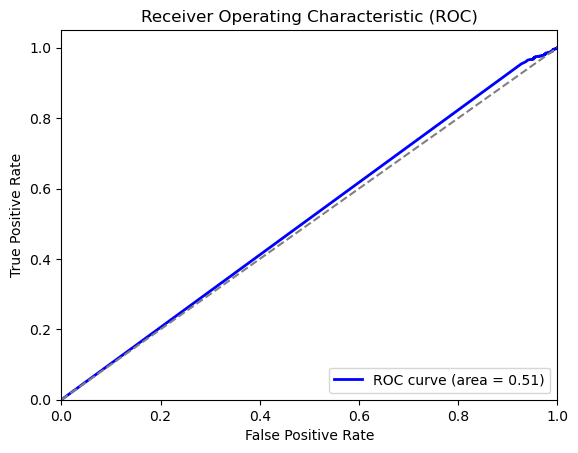

In [5]:



import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf




y_true = []
y_pred = []


for X_batch, y_batch in val_ds:
    y_true.append(y_batch)
    y_pred.append(best_model.predict(X_batch))

# Convert lists to numpy arrays
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

#For ROC, use probabilities for the positive class
#If using softmax output, take the probability of class 1 (positive class)
if y_pred.shape[1] == 2: 
    y_pred = y_pred[:, 1]

#Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

#Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Reference line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
